In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import os
# sk-learn imports are below

In [2]:
from utilities import *

In [3]:
# I promise I already read all the warnings and they are erroneous or irrelevant
import warnings
warnings.filterwarnings("ignore")

In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
pd.set_option('display.max_columns', 100)
plt.ioff()

sns.set_context('talk')
sns.set_style('darkgrid')

## Computational Setup

### Multi-Processing

Note: My hardware (2.7 GHz Intel Core i5) has two physical CPU cores each supporting hyper-threading and so appearing to the OS as 4 cores. I have found experimentally (n=1) that setting n_jobs = 2 leads to no speedup, as only one physical core is used. Only with n_jobs = 4 is a 2x speedup achieved.

In [5]:
# Set to false if you don't want to use all of your computer at once
go_for_broke = True

In [6]:
if go_for_broke:
    n_jobs = os.cpu_count()
else:
    n_jobs = 1
    
print(f'Configured to use {n_jobs} out of {os.cpu_count()} cpu cores visible to the OS')

Configured to use 4 out of 4 cpu cores visible to the OS


### Model Fitting
Models can be loaded from disk; some take a while to fit

In [7]:
# On false, all models wiil be refit (takes a while!)
load_from_disk = True

# Load the Data
The first task will be classify the columns as:
- irrelevant
- categorical predictor (including boolean)
- ordinal predictor
- main target
- subsidiary target (questions that obviously reveal the answer to the main target)

I highly recommend you look at the codebook with a spreadsheet viewer and not the dataframe itself

In [8]:
df       = pd.read_csv('dataset.csv' , index_col = 0)
codebook = pd.read_csv('codebook.csv', index_col = 0)

# Classify the Columns

## The Target Variable

Target variables:

- Questions 36–40 are explicitly career-plan related and contain our target
- Questions 41–54 have the potential to be quite career related and need to be screened for data leakage

In [9]:
def getQs(q):
    all_qs = codebook.index
    qs     = lfilter(lambda row : re.match(q, row), all_qs)
    return codebook.loc[qs]

In [10]:
getQs('Q38')

,Question Text,var_type,checkbox_text,notes,num_categories,num_missing
Q38.a,Research in academia,Ordinal,NaN,Likelihood of pursuing career path,6,82
Q38.b,Research in industry,Ordinal,NaN,Likelihood of pursuing career path,6,135
Q38.c,Research within government or non-profit,Ordinal,NaN,Likelihood of pursuing career path,6,196
Q38.d,Non-research in academia,Ordinal,NaN,Likelihood of pursuing career path,6,223
Q38.e,Medical research,Ordinal,NaN,Likelihood of pursuing career path,6,185
Q38.f,Non-research in industry,Ordinal,NaN,Likelihood of pursuing career path,6,262
Q38.g,Non-research in government or non-profit,Ordinal,NaN,Likelihood of pursuing career path,6,290


In [11]:
def getQNum(q):
    num = re.match('Q(\d*)', q)
    if not num:
        return None
    num = int(num.group(1))
    return num

In [12]:
def filterQRange(low, hi, exclude = True):
    def filterQ(q):
        n = getQNum(q)
        if not n:
            return exclude
        else:
            if low <= n <= hi:
                return not exclude
            else:
                return exclude
    
    return filterQ

The target will be anyone likely or very likely (4 or 5) to pursue research in academia

In [13]:
target_all = (df['Q38.a'] >= 4).rename('Academic Research Likely')
print(f'{sum(target_all)/len(target_all) : .1%} are Likely to Pursue Academic Research')

 71.0% are Likely to Pursue Academic Research


In [14]:
def bar_plot(col, name=''):
    return plot(sns.countplot, y = df[col].rename(name), hue = target_all)

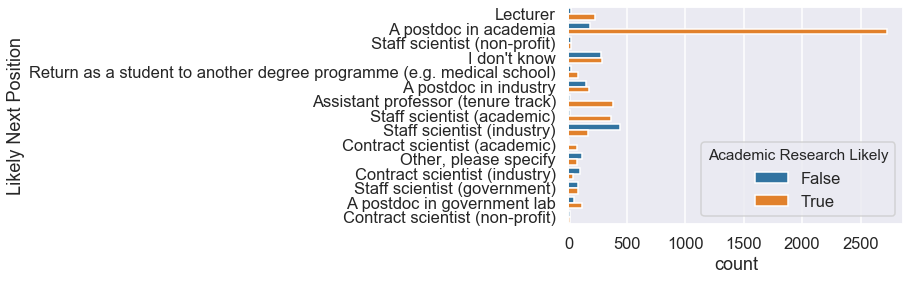

In [15]:
bar_plot('Q40', 'Likely Next Position')

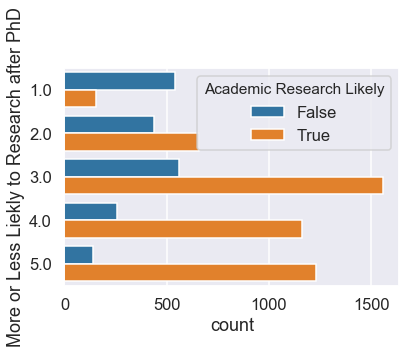

In [16]:
bar_plot('Q43.a', 'More or Less Liekly to Research after PhD')

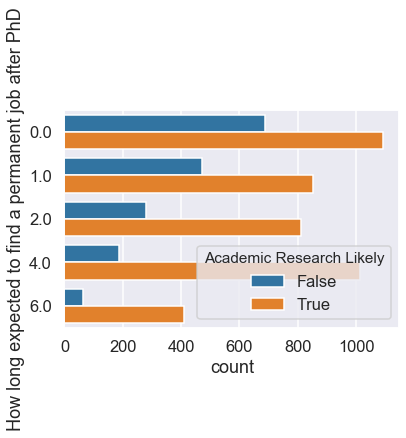

In [17]:
bar_plot('Q42', 'How long expected to find a permanent job after PhD')

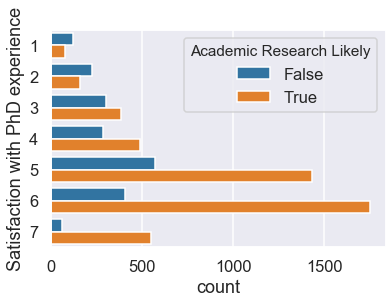

In [18]:
bar_plot('Q19.a', 'Satisfaction with PhD experience')

In [19]:
def checkbox_plot(q, label_col = 'checkbox_text'):
    qs           = getQs(q)
    title        = qs['Question Text'].iloc[0]
    labels       = qs[label_col].rename(title)
    data         = df[qs.index]
    data.columns = labels
    data         = pd.concat([data, target_all], axis = 'columns')
    data = data.melt(id_vars='Academic Research Likely', var_name=title)
    data = data[data.value]
    return plot(sns.countplot, y = title, data = data, hue = 'Academic Research Likely')

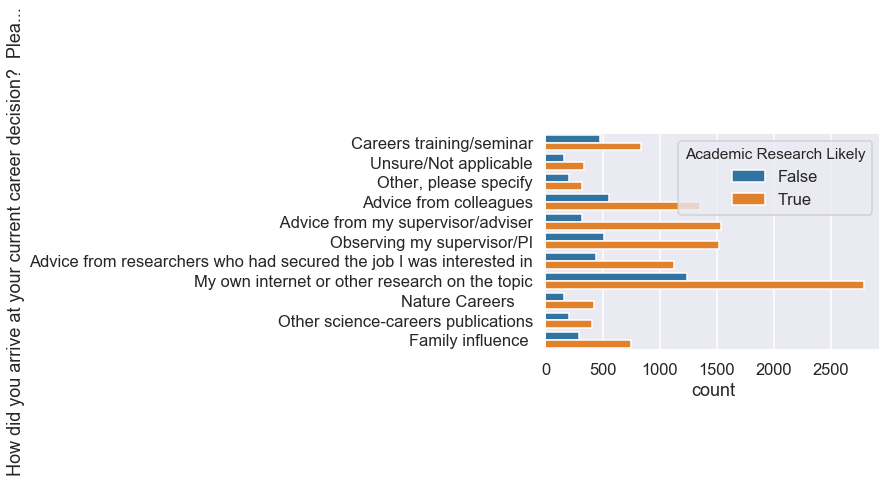

In [20]:
checkbox_plot('Q45')

In [21]:
fig, ax = plt.subplots(figsize = (10, 10))
sns.set_style('darkgrid')
sns.countplot(x = target_all, alpha = 0.8, palette= ['grey','lightgreen'], ax = ax)
ax.set_title('Pursuing Academic Research')
ax.set_ylabel('Count')
fig
fig.savefig('./figures/counts.pdf')

# Model Building

In [22]:
import sklearn.preprocessing   as pre
import sklearn.pipeline        as pipe
import sklearn.impute          as imp
import sklearn.compose         as pipe2
import sklearn.dummy           as dum
import sklearn.metrics         as metr
import sklearn.linear_model    as lin
import sklearn.model_selection as cv
import sklearn.tree            as tree
import sklearn.ensemble        as ensem

from joblib import dump, load

In [23]:
sns.set_style('dark')

## Setup

### Assemble the Data and Train/Test Split

In [24]:
codebook.var_type.value_counts()

Check Box      122
Ordinal         80
Categorical     17
Boolean          4
Name: var_type, dtype: int64

In [25]:
# Prevent Data Leakage
leakage_filter = filterQRange(36, 54)

categorical_vars = codebook[codebook.var_type.isin(['Boolean', 'Categorical'])].index.tolist()
categorical_vars = lfilter(leakage_filter, categorical_vars)
categorical_vars.remove('ID.site') # Quite irrelevant

ordinal_vars = codebook[codebook.var_type == 'Ordinal'].index.tolist()
ordinal_vars = lfilter(leakage_filter, ordinal_vars)

checkbox_vars = codebook[codebook.var_type == 'Check Box'].index.tolist()
checkbox_vars = lfilter(leakage_filter, checkbox_vars)

In [26]:
len(checkbox_vars)

44

In [27]:
len(ordinal_vars)

49

In [28]:
len(categorical_vars)

18

In [29]:
X_checkbox    = df.loc[:,checkbox_vars].astype(int)
X_ord         = df.loc[:,ordinal_vars]
X_cat         = df.loc[:,categorical_vars].astype(str)
X_cat         = pd.get_dummies(X_cat, drop_first=False)
X_all         = pd.concat([X_checkbox, X_ord, X_cat], axis = 'columns')

categorical_vars = X_cat.columns.tolist()

In [30]:
X_train, X_test, target_train, target_test = cv.train_test_split(X_all, target_all, random_state = 42)

#Aliases. Goal is to avoid accidentally training on test data.
X      = X_train
target = target_train
y      = target_train
y_test = target_test

### Imputation

For the ordinal variables we need to impute.

For the rankings, impute to bottom

For the 1-5 scales, impute to most common

In [31]:
# Identify the ranking variables
ordinal_book     = codebook.loc[ordinal_vars]
ranking_book     = ordinal_book[ordinal_book.notes.str.contains('[rR]anking').fillna(False)]
ranking_vars     = ranking_book.index.tolist()
non_ranking_vars = list_diff(ordinal_vars, ranking_vars)

In [32]:
# We can fill with bottom = 14
X[ranking_vars].max().value_counts()

14.0    14
dtype: int64

In [33]:
# Imputation plan for the ordinal variables
imputer = pipe2.ColumnTransformer([
    ('bottom', imp.SimpleImputer(strategy = 'constant', fill_value = 14), ranking_vars),
    ('freq'  , imp.SimpleImputer(strategy = 'most_frequent')            , non_ranking_vars)],
remainder = 'passthrough')

### Other Modelling Utilities

In [34]:
# Dict to record model data
models = {}

In [35]:
# Cross-Validation Splitter
splitter = cv.RepeatedStratifiedKFold(n_splits = 5, n_repeats = 1, random_state = 42)

Handle persistence and timing of fits

In [36]:
# Attempts to load from the disk if the load_from_disk option is set
#  Otherwise fits the model
#  Returns the fitted model and a model_data dict
#  Inserts the model_data_dict into the models dictionary
def fit_or_load_model(model, model_name, force_fit = False):
    model_not_found = False
    model_data = {'model' : model}
    if load_from_disk and not force_fit:
        try:
            model = load(f'./models/{model_name}.joblib')
        except:
            model_not_found = True
        else:
            print(f'Loading model from disk')
            fit_time = get_fit_time(model_name)
            model_data['fit_time'] = fit_time
            print(f'''{fit_time} seconds elapsed in original fitting''')
              
    if not load_from_disk or model_not_found or force_fit:
        print(f'Fitting model {model_name}')

        # Fit the Model
        Timer.start()
        model.fit(X, y)
        Timer.end()

        # Write information
        model_data['fit_time'] = Timer.time
        dump(model, f'./models/{model_name}.joblib')
        write_fit_time(model_name, model_data['fit_time'])
    
    models[model_name] = model_data
    
    return model, model_data

# Modelling

## Baseline Model

In [37]:
model = dum.DummyClassifier(strategy = 'most_frequent')

In [38]:
model, model_data = fit_or_load_model(model, 'baseline', force_fit = True)

Fitting model baseline
0.0 seconds elapsed


In [39]:
y_hat = model.predict(X_test)
model_data['report'] = metr.classification_report(y_test, y_hat, zero_division = 0, output_dict=True)
print(metr.classification_report(y_test, y_hat, zero_division=0))

              precision    recall  f1-score   support

       False       0.00      0.00      0.00       498
        True       0.71      1.00      0.83      1205

    accuracy                           0.71      1703
   macro avg       0.35      0.50      0.41      1703
weighted avg       0.50      0.71      0.59      1703



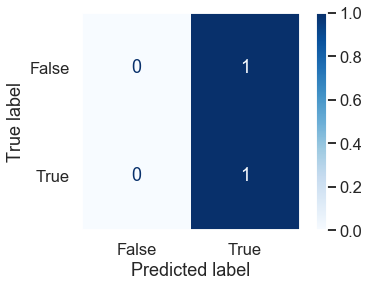

In [40]:
# Rows are normalized
plot(metr.plot_confusion_matrix, model, X_test, y_test, cmap=plt.cm.Blues, normalize = 'true')

## 1 – Logistic Regression – Unweighted

### 1 – Setup

In [41]:
learner = pipe.Pipeline([
    ('impute' , imputer),
    ('learn'  , lin.LogisticRegression(max_iter = 10000))
])

In [42]:
param_grid = {
     'penalty'    : ['elasticnet'],
     'l1_ratio'   : np.linspace( 0, 1, 6),
     'C'          : np.logspace(-3, 2, 6),
     'solver'     : ['saga']
}
param_grid = {'learn__' + k : list(v) for k, v in param_grid.items()}

In [43]:
model = cv.GridSearchCV(learner,
                        param_grid,
                        scoring = 'neg_log_loss',
                        cv = splitter,
                        n_jobs = n_jobs,
                        verbose = 1)

### 1 – Fit

In [44]:
model, model_data = fit_or_load_model(model, 'logistic')

Loading model from disk
1827.281 seconds elapsed in original fitting


In [45]:
model_data['get_time_per_fold'] = get_time_per_fold(model_data, param_grid, splitter)
print(f'''{model_data['get_time_per_fold']} seconds per fold''')

10.15 seconds per fold


### 1 – Evaluate

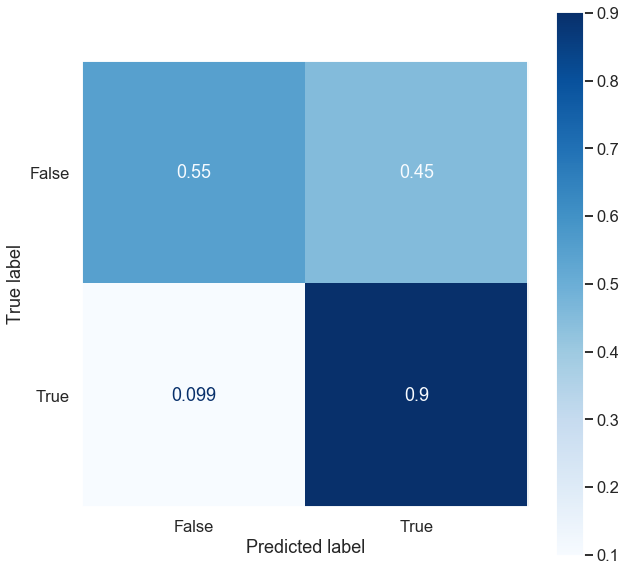

In [46]:
# Rows are normalized
sns.set_style('dark')
fig, ax = plt.subplots(figsize = (10, 10))
metr.plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues, normalize = 'true', ax = ax)
fig.savefig('./figures/logistic-confusion.pdf')
fig

In [47]:
y_hat = model.predict(X_test)
model_data['report'] = metr.classification_report(y_test, y_hat, zero_division = 0, output_dict=True)
print(metr.classification_report(y_test, y_hat, zero_division=0))

              precision    recall  f1-score   support

       False       0.70      0.55      0.61       498
        True       0.83      0.90      0.86      1205

    accuracy                           0.80      1703
   macro avg       0.76      0.72      0.74      1703
weighted avg       0.79      0.80      0.79      1703



In [48]:
report = pd.DataFrame.from_records([model_data['report']['False'], model_data['report']['True']], index = [True, False])
report.to_csv('./tables/logistic-report.csv')
report

,precision,recall,f1-score,support
True,0.696429,0.548193,0.613483,498
False,0.828375,0.901245,0.863275,1205


AUC:  82.47%


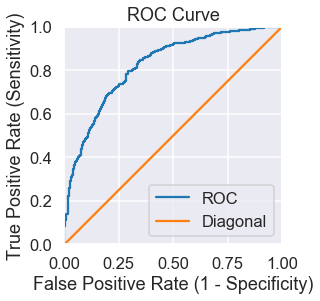

In [49]:
y_p = model.decision_function(X_test)
fpr, tpr, thresholds = metr.roc_curve(y_test, y_p)
model_data['auc'] = metr.roc_auc_score(y_test, y_p)
model_data['roc'] = (fpr, tpr)
print(f'AUC: {model_data["auc"] : .2%}')
plot_roc_curve(fpr, tpr)

In [50]:
model_data['log_loss_test']  = metr.log_loss(y_test, model.predict_proba(X_test))
model_data['log_loss_train'] = metr.log_loss(y, model.predict_proba(X))
print(f'Log Loss - Train : {model_data["log_loss_train"] :.2}\n'
      f'Log Loss - Test  : {model_data["log_loss_test"]  :.2}\n')

Log Loss - Train : 0.42
Log Loss - Test  : 0.45



### 1 – Inspect

In [51]:
model_data['best_params'] = model.best_params_
print_dict(model.best_params_)

learn__C        : 0.1
learn__l1_ratio : 0.4
learn__penalty  : elasticnet
learn__solver   : saga


In [52]:
coefs = pd.DataFrame.from_records(zip(X.columns, model.best_estimator_.get_params()['learn'].coef_[0]),
                              columns = ['variable', 'coefficient'])

coefs = coefs.sort_values('coefficient', ascending = False)
coefs.loc[:,'coefficient'] = coefs.coefficient * 10/np.log(10) # Convert to decibans or decibels

In [53]:
sns.set_style('darkgrid')

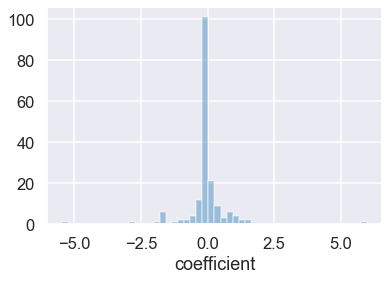

In [54]:
# Distribution of coefficients
plot(sns.distplot, coefs.coefficient, kde = False)

In [55]:
print(f'{sum(coefs.coefficient == 0)} features selected out of {len(coefs)}')

67 features selected out of 179


In [56]:
coefs['abs_coeff'] = np.abs(coefs.coefficient)

def map_coeff(row):
    if row.variable in ranking_vars:
        return -row.coefficient
    else:
        return row.coefficient

coefs.loc[:,'coefficient'] = coefs.apply(map_coeff, axis = 'columns')

top_coeffs = coefs.sort_values('abs_coeff', ascending = False).iloc[:15]

In [57]:
top_coeffs.set_index('variable', inplace = True)

In [58]:
q_to_english_dict = {
    'Q3_I want to pursue an academic career'                                              : 'Went to grad school to pursue Academic Career',
    'Q15.m'                                                                               : 'Concern about mental health due to PhD (Rank)',
    'ID.language_French'                                                                  : 'Took survey in French',
    'Q17_A chance to consider professional options '                                      : 'Enjoyable part of PhD: Chance to consider professional options',
    'Q22.h'                                                                               : 'Satisfaction with Number of Publications (Ord)',
    'Q20_Significantly worsened'                                                          : 'Level of satisfaction has decreased since starting',
    'country_Germany'                                                                     : 'Go to school in Germany',
    'Q17_Knowing I will have a chance to use my skills in a non-research science job'     : 'Enjoyable part of PhD: use skills in non-research',
    'Q17_Knowing I will have a chance for a non-academic research job'                    : 'Enjoyable part of PhD: chance for non-academic research',
    'Q3_I want to pursue a non-academic career'                                           : 'Went to grad school to pursue non-Academic Career',
    'Q3_I wanted to continue pursuing my research'	                                      : 'Went to grad school to continue pursing my research',
    'Q17_Creativity'	                                                                    : 'Enjoyable part of PhD: Creativity',
    'Q15.n'	                                                                              : 'Concern about poor support/ack for family responsiblities',
    'ID.language_Chinese (Simplified)'	                                                  : 'Took survey in Chinese',
    'Q15.l'	                                                                              : 'Concern about imposter syndrome',
}

In [59]:
top_coeffs = top_coeffs.rename(q_to_english_dict).reset_index().sort_values('coefficient', ascending = False)
top_coeffs

,variable,coefficient,abs_coeff
0,Went to grad school to pursue Academic Career,5.969548,5.969548
3,Concern about mental health due to PhD (Rank),1.982985,1.982985
10,Went to grad school to continue pursing my res...,1.491284,1.491284
11,Enjoyable part of PhD: Creativity,1.462087,1.462087
12,Concern about poor support/ack for family resp...,1.337207,1.337207
13,Took survey in Chinese,1.277336,1.277336
14,Concern about imposter syndrome,-1.244531,1.244531
9,Took survey in French,-1.577997,1.577997
8,Enjoyable part of PhD: Chance to consider prof...,-1.586413,1.586413
7,Satisfaction with Number of Publications (Ord),-1.590818,1.590818


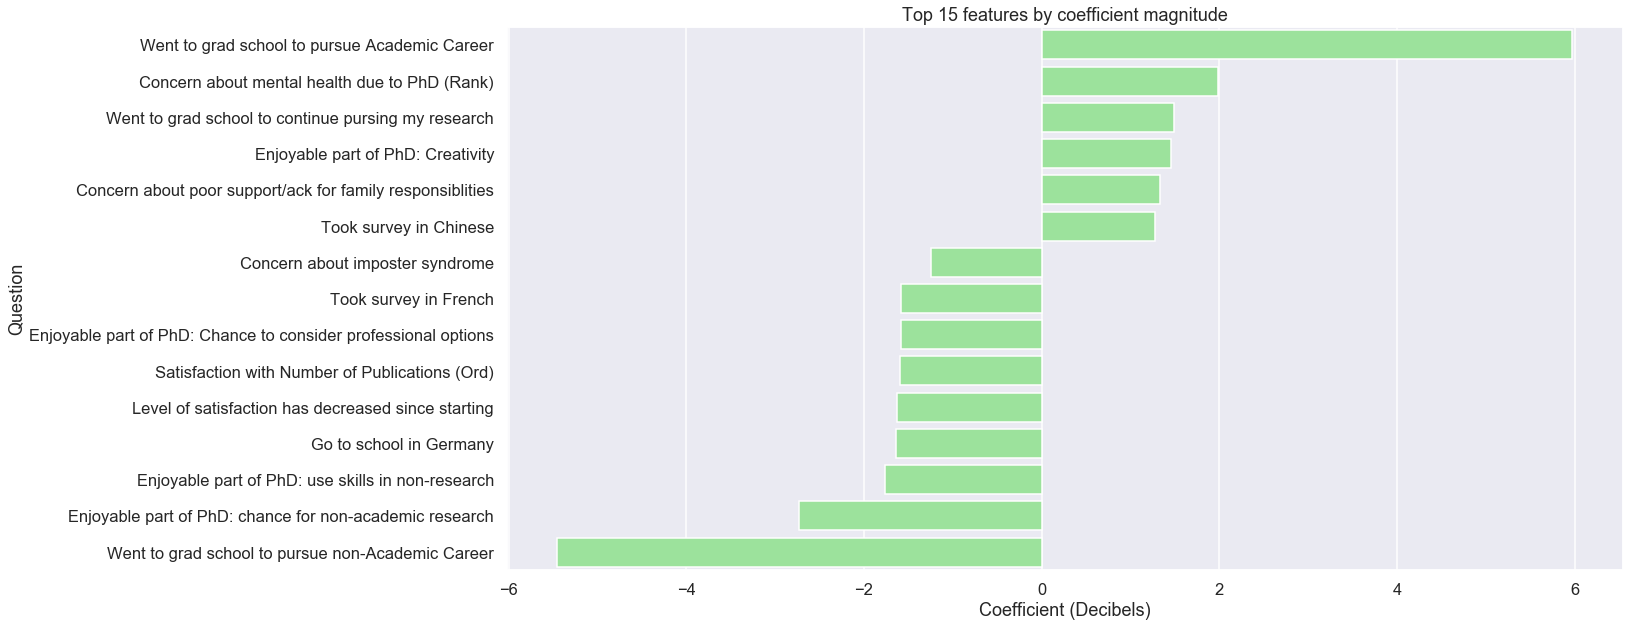

In [60]:
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize = (20, 10))
sns.barplot(y = 'variable', x = 'coefficient', data = top_coeffs, color = 'lightgreen', ax = ax)
ax.set_xlabel('Coefficient (Decibels)')
ax.set_ylabel('Question')
ax.set_title('Top 15 features by coefficient magnitude')
# doesn't work, do manually:
# fig.savefig('./figures/logistic-features.png')
fig

## 2 – Logistic Regression – Balanced Weighting

In [61]:
learner = pipe.Pipeline([
    ('impute' , imputer),
    ('learn'  , lin.LogisticRegression(max_iter = 10000, class_weight = 'balanced'))
])

In [62]:
# To decrease fitting time, restrict the Grid Search to be near what was found last time

param_grid = {
     'penalty'    : ['elasticnet'],
     'l1_ratio'   : np.linspace(0.2, 0.6, 3),
     'C'          : np.logspace( -2, 0  , 3),
     'solver'     : ['saga']
}
param_grid = {'learn__' + k : list(v) for k, v in param_grid.items()}

In [63]:
model = cv.GridSearchCV(learner,
                        param_grid,
                        scoring = 'neg_log_loss',
                        cv = splitter,
                        n_jobs = n_jobs,
                        verbose = 1)

In [64]:
# Now proceed by copy-pasta
model, model_data = fit_or_load_model(model, 'logistic-weighted')

Loading model from disk
348.948 seconds elapsed in original fitting


In [65]:
model_data['get_time_per_fold'] = get_time_per_fold(model_data, param_grid, splitter)
print(f'''{model_data['get_time_per_fold']} seconds per fold''')

7.75 seconds per fold


### 2 – Evaluate

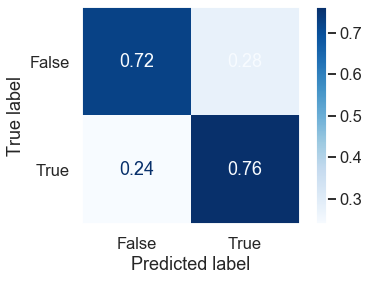

In [66]:
# Rows are normalized
sns.set_style('dark')
plot(metr.plot_confusion_matrix, model, X_test, y_test, cmap=plt.cm.Blues, normalize = 'true')

In [67]:
y_hat = model.predict(X_test)
model_data['report'] = metr.classification_report(y_test, y_hat, zero_division = 0, output_dict=True)
print(metr.classification_report(y_test, y_hat, zero_division=0))

              precision    recall  f1-score   support

       False       0.56      0.72      0.63       498
        True       0.87      0.76      0.81      1205

    accuracy                           0.75      1703
   macro avg       0.71      0.74      0.72      1703
weighted avg       0.78      0.75      0.76      1703



AUC:  82.37%


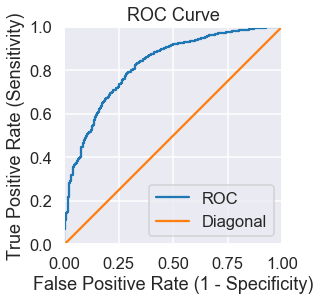

In [68]:
y_p = model.decision_function(X_test)
fpr, tpr, thresholds = metr.roc_curve(y_test, y_p)
model_data['auc'] = metr.roc_auc_score(y_test, y_p)
model_data['roc'] = (fpr, tpr)
print(f'AUC: {model_data["auc"] : .2%}')
plot_roc_curve(fpr, tpr)

In [69]:
model_data['log_loss_test']  = metr.log_loss(y_test, model.predict_proba(X_test))
model_data['log_loss_train'] = metr.log_loss(y, model.predict_proba(X))
print(f'Log Loss - Train : {model_data["log_loss_train"] : .2}\n'
      f'Log Loss - Test  : {model_data["log_loss_test"] : .2}\n')

Log Loss - Train :  0.47
Log Loss - Test  :  0.51



## 3 – Decision Tree
Note – we would ideally not 1-hot encode; but sk-learn doesn't support this

In [70]:
learner = pipe.Pipeline([
    ('impute' , imputer),
    ('learn'  , tree.DecisionTreeClassifier(random_state = 42))
])

In [71]:
param_grid = {
    'criterion'         : ['gini', 'entropy'],
    'max_depth'         : [None, 3, 5, 10],
    'min_samples_leaf'  : [1, 2, 5 , 10],
    'max_features'      : [None, 'sqrt', 0.5],
    'max_leaf_nodes'    : [None, 50, 100],
    'ccp_alpha'         : [0, 0.1, 1, 5, 10],
    'class_weight'      : [None, 'balanced']
}
param_grid = {'learn__' + k : list(v) for k, v in param_grid.items()}

In [72]:
model = cv.GridSearchCV(learner,
                        param_grid,
                        cv = splitter,
                        n_jobs = n_jobs,
                        verbose = 1)

In [73]:
# Now proceed by copy-pasta
model, model_data = fit_or_load_model(model, 'decision-tree')

Loading model from disk
711.227 seconds elapsed in original fitting


In [74]:
model_data['get_time_per_fold'] = get_time_per_fold(model_data, param_grid, splitter)
print(f'''{model_data['get_time_per_fold']} seconds per fold''')

0.05 seconds per fold


### 3 – Evaluate

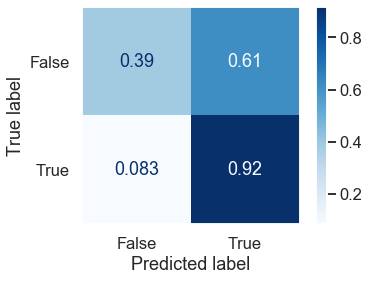

In [75]:
# Rows are normalized
sns.set_style('dark')
plot(metr.plot_confusion_matrix, model, X_test, y_test, cmap=plt.cm.Blues, normalize = 'true')

In [76]:
y_hat = model.predict(X_test)
model_data['report'] = metr.classification_report(y_test, y_hat, zero_division = 0, output_dict=True)
print(metr.classification_report(y_test, y_hat, zero_division=0))

              precision    recall  f1-score   support

       False       0.66      0.39      0.49       498
        True       0.78      0.92      0.84      1205

    accuracy                           0.76      1703
   macro avg       0.72      0.65      0.67      1703
weighted avg       0.75      0.76      0.74      1703



In [77]:
# True class is in second column
model.classes_

array([False,  True])

AUC:  76.87%


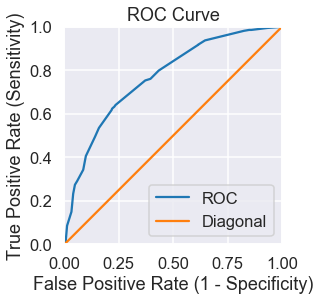

In [78]:
y_p = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = metr.roc_curve(y_test, y_p)
model_data['auc'] = metr.roc_auc_score(y_test, y_p)
model_data['roc'] = (fpr, tpr)
print(f'AUC: {model_data["auc"] : .2%}')
plot_roc_curve(fpr, tpr)

In [79]:
model_data['log_loss_test']  = metr.log_loss(y_test, y_p)
model_data['log_loss_train'] = metr.log_loss(y, model.predict_proba(X)[:,1])
print(f'Log Loss - Train : {model_data["log_loss_train"] : .2}\n'
      f'Log Loss - Test  : {model_data["log_loss_test"]  : .2}\n')

Log Loss - Train :  0.45
Log Loss - Test  :  0.59



### 3 – Inspect

In [80]:
model_data['best_params'] = model.best_params_
print_dict(model.best_params_)

learn__ccp_alpha        : 0
learn__class_weight     : None
learn__criterion        : entropy
learn__max_depth        : 5
learn__max_features     : None
learn__max_leaf_nodes   : 50
learn__min_samples_leaf : 2


In [81]:
from IPython.display import Image  
from pydotplus import graph_from_dot_data

In [82]:
best_tree = model.best_estimator_.get_params()['learn']

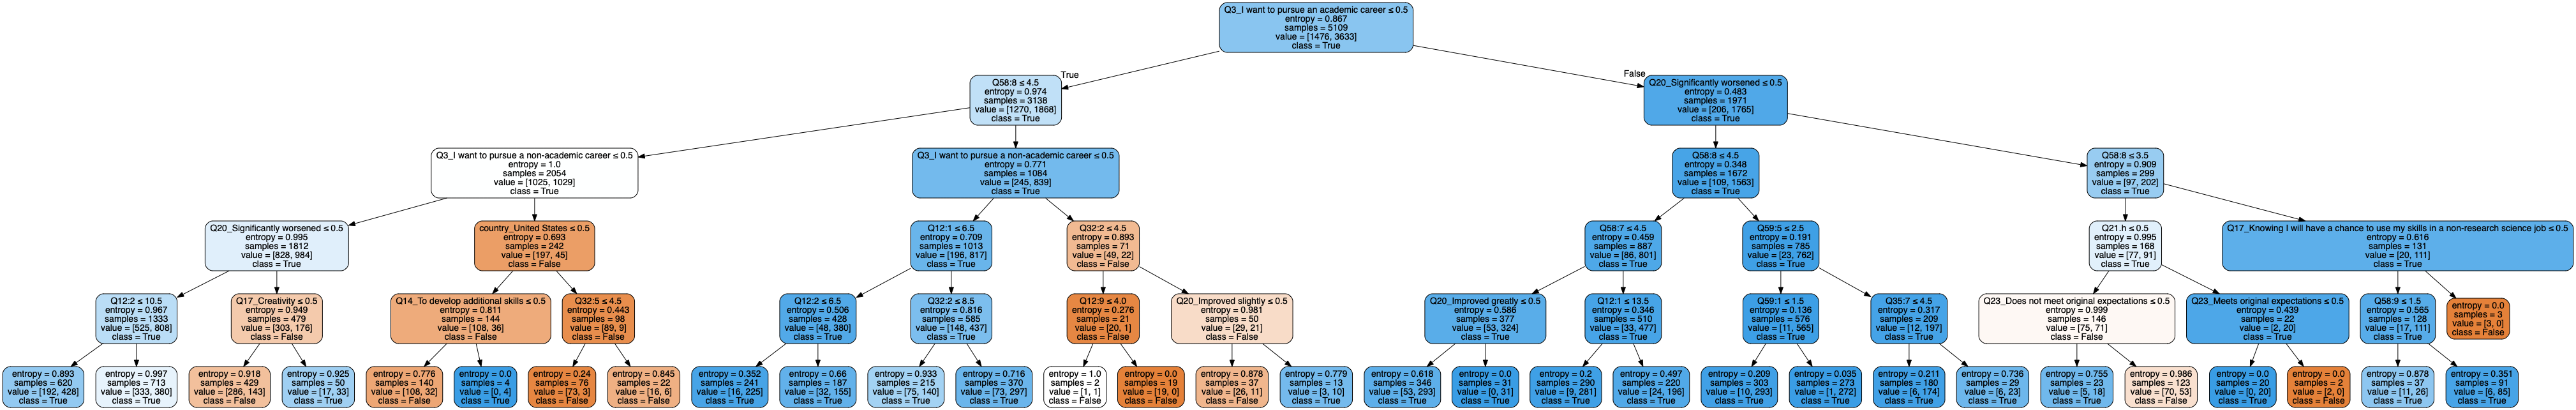

In [83]:
# Copy-pasta cell
# Create DOT data
dot_data = tree.export_graphviz(
                           best_tree, out_file=None, 
                           feature_names=X.columns,  
                           class_names=np.unique(y).astype('str'), 
                           filled=True, rounded=True, special_characters=True)

# Draw graph
graph = graph_from_dot_data(dot_data)  

# Show graph
Image(graph.create_png())

In [84]:
q_to_english_dict['Q58:7'] = 'East Asian'
q_to_english_dict['Q58:8'] = 'Pacific Islander'
q_to_english_dict['Q12:1'] = 'Studied outside home country because of: specific University'
q_to_english_dict['Q12:2'] = 'Studied outside home country because of: lack of quality PhD programmes in my home country'
q_to_english_dict['Q32:2'] = 'Bullying experienced by another student'
q_to_english_dict['Q21.h'] = 'Since starting, level of satisfaction has increased for: number of publications.'

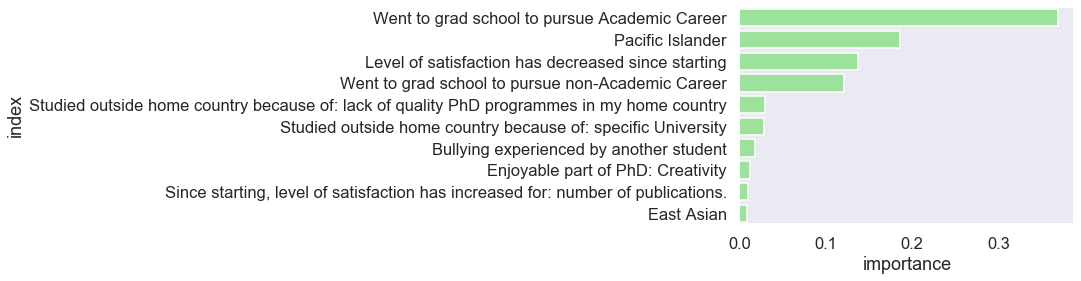

In [85]:
def plot_feat_impt(importances):
    feat_impt = pd.Series(importances, index = X.columns)
    drop_by_rule(feat_impt, feat_impt == 0)
    feat_impt = feat_impt.sort_values(ascending = False)
    feat_impt = feat_impt.rename(q_to_english_dict).iloc[:10]
    feat_impt.name = 'importance'
    feat_impt = feat_impt.reset_index().rename({})
    return plot(sns.barplot, x = 'importance', y = 'index', data = feat_impt, color = 'lightgreen')

plot_feat_impt(best_tree.feature_importances_)

In [86]:
plt.close('all') # Prevent memory leakage by doing this occasionally

## 4 – Random Forest
I was unable to get Random Forests implemented properly (i.e. without cross-validation and using OOB sampling) using default sk-learn.

So here is a roll your own solution

In [87]:
class RandomForestClassifierCV(ensem.RandomForestClassifier):
    '''
        This class implements cross validation *ONLY* for the 
        number of estimators. It does this using OOB scoring and
        warm starts. In theory this should be doable in sk-learn by
        default, but I am unable to make it work without this
        roll-you-own solution
        
        Note: always computes up to max_estimators. Then picks the
        smallest possible within the tolerance. There are presumably
        better ways to detect stabilization.
        
        For other hyperparemeters, use GridSearch, below
    '''
    
    def __init__(self, max_estimators = 500, tolerance = 0.005, **kwargs):
        kwargs['warm_start']   = True
        kwargs['oob_score']    = True
        super().__init__(**kwargs)
        self.max_estimators = max_estimators
        self.tolerance      = tolerance
        self.use_oob_score  = True
        self.init_kwargs    = kwargs
        
    def reset_and_clone(self):
        return RandomForestClassifierCV(max_estimators = self.max_estimators,
                                        tolerance      = self.tolerance, 
                                       **self.init_kwargs)
        
    def score(self, *args, **kwargs):
        if self.use_oob_score:
            return self.best_score
        else:
            return super().score(*args, **kwargs)
    
    def fit(self, X, y):
        self.n_est_scores_ = {}
        for i in range(100, self.max_estimators + 1, 100):
            self.n_estimators = i
            super().fit(X, y)
            self.n_est_scores_[i] = self.oob_score_
            
        self.best_score = max(self.n_est_scores_.values())
        self.best_n     = next(n for n, v in self.n_est_scores_.items() if v > self.best_score - self.tolerance)
            
        return self
    
    def finalize(self, X, y):
        self.use_oob_score = False
        
        self.set_params(warm_start = False)
        
        self.n_estimators = self.best_n
        super().fit(X, y)
        
    def get_params(self, *args, **kwargs):
        out = ensem.RandomForestClassifier().get_params()
        out['max_estimators'] = self.max_estimators
        out['tolerance']      = self.tolerance
        return out

In [88]:
class GridSearch():
    '''
        Grid Search *without* cross validation.
        Doesn't implement full feature set of GridSearch
        
        Just fit, predict in a bare-bones fashion
        
        Designed for use with RandomForestCV above
    '''
    
    def __init__(self, estimator, param_grid, verbose = 0):
        self.param_grid       = cv.ParameterGrid(param_grid)
        self.parent_estimator = estimator
        self.verbose          = verbose
        
    def fit(self, X, y):
        self.best_params = None
        self.best_model  = None
        self.best_score  = 0
        
        progress_count   = 0
        if self.verbose:
            print(f'{len(self.param_grid)} Iterations to do')
        Timer.start()
        
        for param_dict in self.param_grid:
            model = self.parent_estimator.reset_and_clone()
            model.set_params(**param_dict)
            model.fit(X, y)
            
            if model.score() > self.best_score:
                self.best_params = param_dict
                self.best_model  = model
                self.best_score  = model.score()
                
            progress_count += 1
            if self.verbose and progress_count % 20 == 0:
                print(f'{progress_count} Done')
                Timer.end()
        
        # This fails if every model somehow had an accuracy of 0...
        assert bool(self.best_params)
        
        self.best_model.finalize(X, y)
        
        return self.best_model
        
    def predict(self, *args, **kwargs):
        return self.best_model.predict(*args, **kwargs)
    
    def score(self, *args, **kwargs):
        return self.best_model.score(*args, **kwargs)

In [89]:
# Limit grid search by (1) being informed from the decision tree;
#                      (2) bias towards weaker learners
param_grid = {
    'criterion'         : ['entropy'],
    'max_depth'         : [None, 1, 3],
    'min_samples_leaf'  : [1, 5 ],
    'max_features'      : [5, 'sqrt'],
    'max_leaf_nodes'    : [None, 10, 50],
    'ccp_alpha'         : [0, 0.1, 1, 10],
    'class_weight'      : [None]
}



In [90]:
learner = RandomForestClassifierCV(n_jobs = n_jobs, random_state = 42, max_samples = 0.9)

model = pipe.Pipeline([
    ('impute' , imputer),
    ('learn'  , GridSearch(learner, param_grid, verbose = 1))
])

In [91]:
# Now proceed by copy-pasta
model, model_data = fit_or_load_model(model, 'random-forest')

Loading model from disk
843.40 seconds elapsed in original fitting


In [92]:
model_data['get_time_per_fold'] = get_time_per_fold(model_data, param_grid, splitter)
print(f'''{model_data['get_time_per_fold']} seconds per fold''')

1.17 seconds per fold


In [93]:
# For simplicity, we are going to unwrap the "roll-your-own" solution
#  I checked and this reproduces the same predictions

n_estimators = model.get_params()['learn'].best_model.best_n
best_params  = model.get_params()['learn'].best_model.get_params()
del best_params['max_estimators']
del best_params['tolerance']
best_params['n_estimators'] = n_estimators

rfc = ensem.RandomForestClassifier(**best_params)

Timer.start()
model = pipe.Pipeline([
    ('impute' , imputer),
    ('learn'  , rfc)
])
model.fit(X, y)
Timer.end()

1.928 seconds elapsed


### 4 – Evaluate

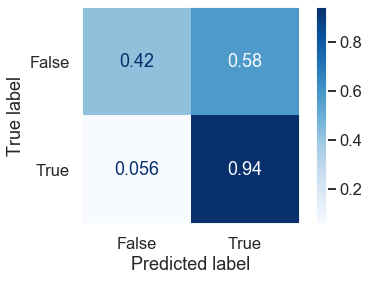

In [94]:
# Rows are normalized
sns.set_style('dark')
plot(metr.plot_confusion_matrix, model, X_test, y_test, cmap=plt.cm.Blues, normalize = 'true')

In [95]:
y_hat = model.predict(X_test)
model_data['report'] = metr.classification_report(y_test, y_hat, zero_division = 0, output_dict=True)
print(metr.classification_report(y_test, y_hat, zero_division=0))

              precision    recall  f1-score   support

       False       0.76      0.42      0.54       498
        True       0.80      0.94      0.86      1205

    accuracy                           0.79      1703
   macro avg       0.78      0.68      0.70      1703
weighted avg       0.79      0.79      0.77      1703



In [96]:
y_p = model.predict_proba(X_test)
model_data['log_loss_test']  = metr.log_loss(y_test, y_p)
model_data['log_loss_train'] = metr.log_loss(y, model.predict_proba(X))
print(f'Log Loss - Train : {model_data["log_loss_train"] : .2}\n'
      f'Log Loss - Test  : {model_data["log_loss_test"]  : .2}\n')

Log Loss - Train :  0.13
Log Loss - Test  :  0.47



AUC:  81.84%


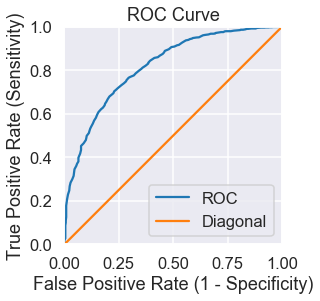

In [97]:
y_p = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = metr.roc_curve(y_test, y_p)
model_data['auc'] = metr.roc_auc_score(y_test, y_p)
model_data['roc'] = (fpr, tpr)
print(f'AUC: {model_data["auc"] : .2%}')
plot_roc_curve(fpr, tpr)

### 4 – Inspect

In [98]:
rfc.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 200,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [99]:
q_to_english_dict['Q58:7']

'East Asian'

In [100]:
q_to_english_dict['Q58:12'] = 'Prefer not to say race/ethnicity'
q_to_english_dict['Q35:3']  = 'Experienced Age Discrimination'
q_to_english_dict['Q12:5']  = 'Studied outside home country because of: Chance to pursue a specific research question'
q_to_english_dict['Q58:9']  = 'American Indian'
q_to_english_dict['Q32:5']  = 'Bullying experienced by online troll'

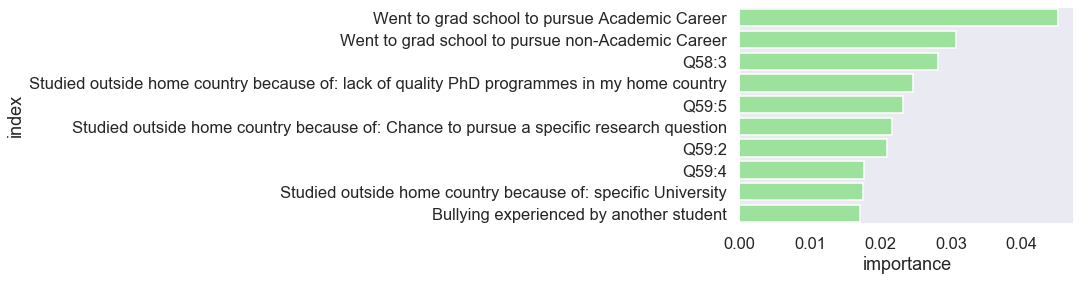

In [101]:
plot_feat_impt(rfc.feature_importances_)

## 5 – Adaboost

In [102]:
adabooster = ensem.AdaBoostClassifier(tree.DecisionTreeClassifier(criterion = 'entropy', random_state = 42),
                                      random_state = 42)
learner    = pipe.Pipeline([
    ('impute' , imputer),
    ('learn'  , adabooster)
])

In [103]:
param_grid = {
    'n_estimators'                      : [50, 100, 200],
    'learning_rate'                     : [0.5, 1],
    'base_estimator__max_depth'         : [1, 3],
    'base_estimator__min_samples_leaf'  : [1, 10],
    'base_estimator__max_features'      : [None, 'sqrt'],
    'base_estimator__max_leaf_nodes'    : [5, 10, 20],
    'base_estimator__ccp_alpha'         : [0, 0.1, 1, 10],
}

param_grid = {'learn__' + k : list(v) for k, v in param_grid.items()}

In [104]:
model = cv.GridSearchCV(learner,
                        param_grid,
                        cv = splitter,
                        n_jobs = n_jobs,
                        verbose = 1)

In [105]:
# Now proceed by copy-pasta
model, model_data = fit_or_load_model(model, 'adaboost')

Loading model from disk
1959.624 seconds elapsed in original fitting


In [106]:
model_data['get_time_per_fold'] = get_time_per_fold(model_data, param_grid, splitter)
print(f'''{model_data['get_time_per_fold']} seconds per fold''')

0.68 seconds per fold


### 5 – Evaluate

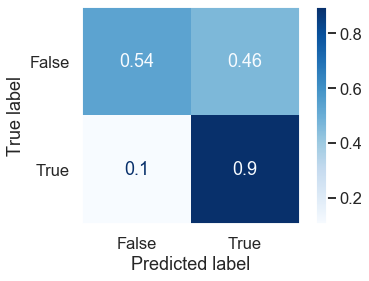

In [107]:
# Rows are normalized
sns.set_style('dark')
plot(metr.plot_confusion_matrix, model, X_test, y_test, cmap=plt.cm.Blues, normalize = 'true')

In [108]:
y_hat = model.predict(X_test)
model_data['report'] = metr.classification_report(y_test, y_hat, zero_division = 0, output_dict=True)
print(metr.classification_report(y_test, y_hat, zero_division=0))

              precision    recall  f1-score   support

       False       0.68      0.54      0.60       498
        True       0.82      0.90      0.86      1205

    accuracy                           0.79      1703
   macro avg       0.75      0.72      0.73      1703
weighted avg       0.78      0.79      0.78      1703



In [109]:
# True class is in second column
model.classes_

array([False,  True])

AUC:  82.62%


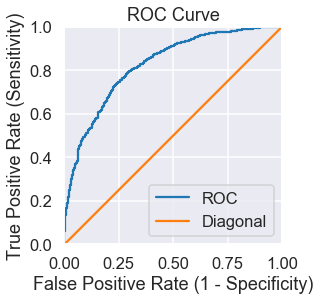

In [110]:
y_p = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = metr.roc_curve(y_test, y_p)
model_data['auc'] = metr.roc_auc_score(y_test, y_p)
model_data['roc'] = (fpr, tpr)
print(f'AUC: {model_data["auc"] : .2%}')
plot_roc_curve(fpr, tpr)

In [111]:
model_data['log_loss_test']  = metr.log_loss(y_test, y_p)
model_data['log_loss_train'] = metr.log_loss(y, model.predict_proba(X)[:,1])
print(f'Log Loss - Train : {model_data["log_loss_train"] : .2}\n'
      f'Log Loss - Test  : {model_data["log_loss_test"]  : .2}\n')

Log Loss - Train :  0.69
Log Loss - Test  :  0.69



### 5 – Inspect

In [112]:
model_data['best_params'] = model.best_params_
print_dict(model.best_params_)

learn__base_estimator__ccp_alpha        : 0
learn__base_estimator__max_depth        : 1
learn__base_estimator__max_features     : None
learn__base_estimator__max_leaf_nodes   : 5
learn__base_estimator__min_samples_leaf : 10
learn__learning_rate                    : 0.5
learn__n_estimators                     : 200


In [113]:
q_to_english_dict['Q35:9']  = 'Prefer not to say what discrimination/harrasment experienced'
q_to_english_dict['Q58:5']  = 'Caribbean race/ethnicity'
q_to_english_dict['Q35:1']  = 'Experienced racial discrimination/harrasment'
q_to_english_dict['Q12:9']  = 'Studied outside home country because of: To experince another culture'
q_to_english_dict['Q58:11'] = 'Other race/ethnicity'
q_to_english_dict['Q32:1']  = 'Bullying experinced by supervisor'

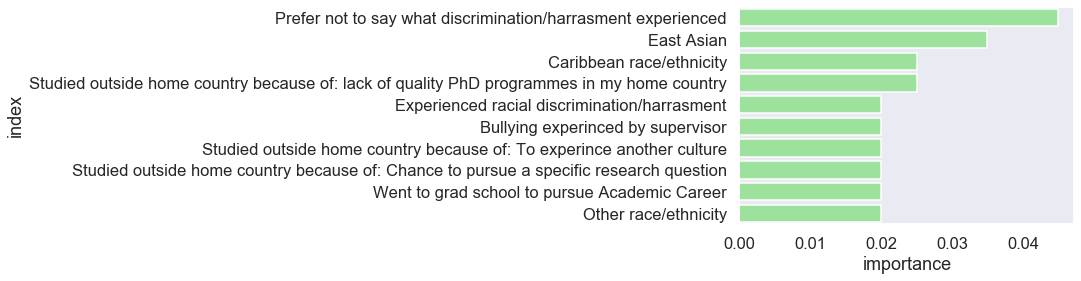

In [114]:
best_clf = model.best_estimator_.steps[1][1]
plot_feat_impt(best_clf.feature_importances_)

In [115]:
plt.close('all') # Prevent memory leakage by doing this occasionally

## 6 – Gradient Boosting

In [116]:
gradientbooster = ensem.GradientBoostingClassifier(random_state = 42, verbose = 1)
learner         = pipe.Pipeline([
    ('impute' , imputer),
    ('learn'  , gradientbooster)
])

In [117]:
param_grid = {
    'n_estimators'      : [50, 100, 200, 500],
    'learning_rate'     : [0.1, 0.5, 1],
    'max_depth'         : [1, 3],
    'min_samples_leaf'  : [1, 10],
    'max_features'      : [None, 'sqrt'],
    'max_leaf_nodes'    : [5, 10, 20, 100, 256],
    'ccp_alpha'         : [0, 0.1, 1, 10],
}

param_grid = {'learn__' + k : list(v) for k, v in param_grid.items()}

In [118]:
model = cv.GridSearchCV(learner,
                        param_grid,
                        cv = splitter,
                        n_jobs = n_jobs,
                        verbose = 1)

In [119]:
# Now proceed by copy-pasta
model, model_data = fit_or_load_model(model, 'gradientboost')

Loading model from disk
6061.631 seconds elapsed in original fitting


In [120]:
model_data['get_time_per_fold'] = get_time_per_fold(model_data, param_grid, splitter)
print(f'''{model_data['get_time_per_fold']} seconds per fold''')

0.63 seconds per fold


### 6 – Evaluate

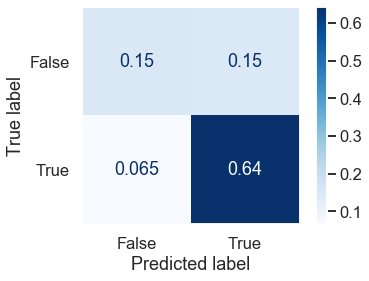

In [121]:
# Rows are normalized
sns.set_style('dark')
plot(metr.plot_confusion_matrix, model, X_test, y_test, cmap=plt.cm.Blues, normalize = 'all')

In [122]:
y_hat = model.predict(X_test)
model_data['report'] = metr.classification_report(y_test, y_hat, zero_division = 0, output_dict=True)
print(metr.classification_report(y_test, y_hat, zero_division=0))

              precision    recall  f1-score   support

       False       0.69      0.50      0.58       498
        True       0.82      0.91      0.86      1205

    accuracy                           0.79      1703
   macro avg       0.75      0.71      0.72      1703
weighted avg       0.78      0.79      0.78      1703



In [123]:
# True class is in second column
model.classes_

array([False,  True])

AUC:  82.29%


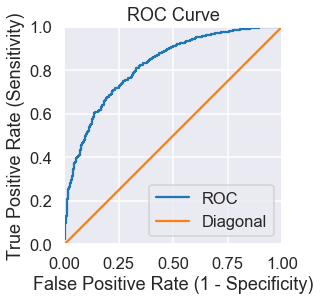

In [124]:
y_p = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = metr.roc_curve(y_test, y_p)
model_data['auc'] = metr.roc_auc_score(y_test, y_p)
model_data['roc'] = (fpr, tpr)
print(f'AUC: {model_data["auc"] : .2%}')
plot_roc_curve(fpr, tpr)

In [125]:
model_data['log_loss_test']  = metr.log_loss(y_test, y_p)
model_data['log_loss_train'] = metr.log_loss(y, model.predict_proba(X)[:,1])
print(f'Log Loss - Train : {model_data["log_loss_train"] : .2}\n'
      f'Log Loss - Test  : {model_data["log_loss_test"]  : .2}\n')

Log Loss - Train :  0.37
Log Loss - Test  :  0.45



### 6 – Inspect

In [126]:
model_data['best_params'] = model.best_params_
print_dict(model.best_params_)

learn__ccp_alpha        : 0
learn__learning_rate    : 0.1
learn__max_depth        : 3
learn__max_features     : None
learn__max_leaf_nodes   : 10
learn__min_samples_leaf : 10
learn__n_estimators     : 100


In [127]:
getQs('Q32')

,Question Text,var_type,checkbox_text,notes,num_categories,num_missing
Q32:1,Who was the perpetrator(s)?,Check Box,Supervisor,Only for students answering yes to experiencin...,2,0
Q32:2,Who was the perpetrator(s)?,Check Box,Another student,Only for students answering yes to experiencin...,2,0
Q32:3,Who was the perpetrator(s)?,Check Box,Postdoc,Only for students answering yes to experiencin...,2,0
Q32:4,Who was the perpetrator(s)?,Check Box,Other academic staff member,Only for students answering yes to experiencin...,2,0
Q32:5,Who was the perpetrator(s)?,Check Box,Online troll,Only for students answering yes to experiencin...,2,0
Q32:6,Who was the perpetrator(s)?,Check Box,"Other, please specify",Only for students answering yes to experiencin...,2,0
Q32:7,Who was the perpetrator(s)?,Check Box,Prefer not to say,Only for students answering yes to experiencin...,2,0


In [128]:
q_to_english_dict['Q59:1'] = 'Caring responsibilities for: children under 12'
q_to_english_dict['Q59:2'] = 'Caring responsibilities for: children over 12'
q_to_english_dict['Q32:4'] = 'Bullying experienced by other academic staff member'

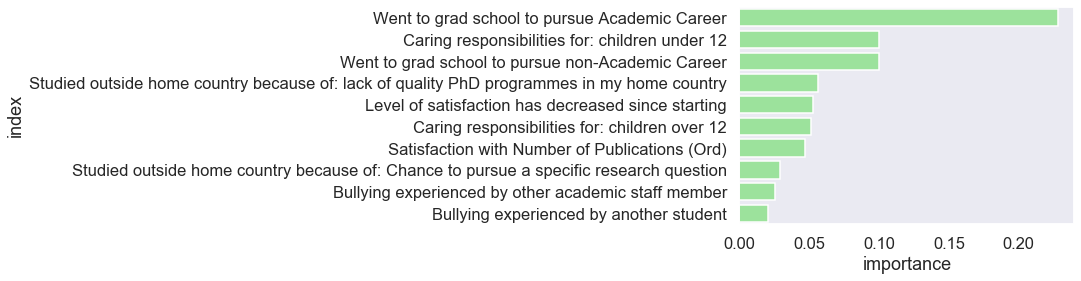

In [129]:
clf = model.best_estimator_.steps[1][1]
plot_feat_impt(clf.feature_importances_)

# Compare

In [130]:
for model_name, model_data in models.items():
    model_data['model_name'] = model_name

model_records = list(models.values())

In [131]:
model_df = pd.io.json.json_normalize(model_records)

In [132]:
table = {
    'model_name'                : 'Model',
    'report.True.precision'     : 'Precision',
    'report.True.recall'        : 'Recall',
    'report.True.f1-score'      : 'F1',
    'auc'                       : 'AUC',
    'log_loss_train'            : 'Cross-Entropy (Train)',
    'log_loss_test'             : 'Cross-Entropy (Test)',
    'fit_time'                  : 'Fit Time',
    'get_time_per_fold'         : 'Time per Fold*',
}

table = model_df[table.keys()].rename(table, axis = 'columns')
table.to_csv('./tables/model-table.csv')

In [133]:
table

,Model,Precision,Recall,F1,AUC,Cross-Entropy (Train),Cross-Entropy (Test),Fit Time,Time per Fold*
0,baseline,0.707575,1.000000,0.828748,NaN,NaN,NaN,0.0,NaN
1,logistic,0.828375,0.901245,0.863275,0.824663,0.418273,0.451884,1827.281,10.15
2,logistic-weighted,0.870142,0.761826,0.812389,0.823736,0.474719,0.511052,348.948,7.75
3,decision-tree,0.783133,0.917012,0.844801,0.768651,0.445660,0.586886,711.227,0.05
4,random-forest,0.798455,0.943568,0.864968,0.818382,0.131440,0.468925,843.40,1.17
5,adaboost,0.823933,0.897095,0.858959,0.826153,0.685634,0.686140,1959.624,0.68
6,gradientboost,0.815809,0.907884,0.859387,0.822902,0.370419,0.453661,6061.631,0.63


In [134]:
model_name_dict = {
         'baseline' : 'Baseline'                ,
         'logistic' : 'Logistic'                ,
'logistic-weighted' : 'Logistic (Balanced)'     ,
    'decision-tree' : 'Decision Tree'           ,
    'random-forest' : 'Random Forest'           ,
         'adaboost' : 'AdaBoost'                ,
    'gradientboost' : 'Gradient Boost'          

}

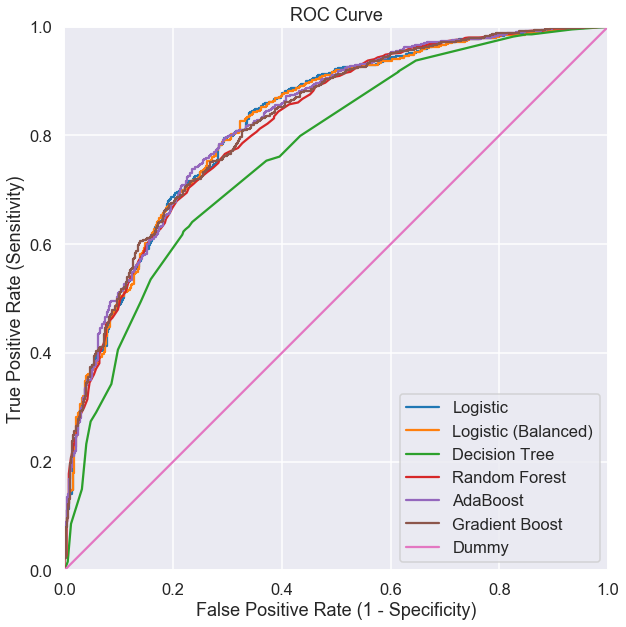

In [135]:
fig, ax = plt.subplots(figsize = (10, 10))

for model in model_records:
    try:
        ax.plot(*model['roc'], label = model_name_dict[model['model_name']])
    except KeyError:
        continue
        
xs = np.linspace(0, 1, len(fpr))
ax.plot(xs, xs, label = 'Dummy')
ax.set_xlim([-0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_title('ROC Curve')
ax.set_xlabel('False Positive Rate (1 - Specificity)')
ax.set_ylabel('True Positive Rate (Sensitivity)')
ax.grid(True)
ax.set_aspect(1)
ax.legend()

# fig.savefig('./figures/roc_curve.pdf')     
fig.savefig('./figures/roc_curve.png')     
fig